In [1]:
!git clone https://github.com/Imsoserious/Dacon-Projects.git

Cloning into 'Dacon-Projects'...
fatal: could not read Username for 'https://github.com': No such device or address


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
# 한글 폰트 설치
# https://pinkwink.kr/1255
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import lightgbm as lgb
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
!pip install workalendar
from workalendar.asia import SouthKorea # 한국의 공휴일, version : 1.1.1

### **모델 선택 이유**
- 상점 매출은 정말 다양한 변수의 영향을 받아 변동성이 매우 큼 
- 반면, 제공 받은 정보는 매우 제한적이므로, variance를 어느 정도 허용하는 것이 예측에 나을 수 있음
- gbmt 계열이 bias, variance를 모두 줄이는데 비해 ensemble 계열은 bias를 줄이는 특징이 있음



- 따라서 대표적인 ensemble 모델인 rf를 사용해 봄





In [0]:
train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/funda_train.csv')
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/submission.csv')
train3 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv') # 추세 정보(lag1,2,3) 있는 파일

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# 시간 변수 생성
# https://dacon.io/index.php?mid=code1&category=217514&document_srl=254639
holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2019))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2018))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2016))[:, 0])]).reset_index(drop=True)

times = train[['transacted_date','transacted_time']].drop_duplicates()
times['date2'] = times['transacted_date']
times['time2'] = times['transacted_time']

times['date2'] = pd.to_datetime(times['date2'])
times['year'] = times['date2'].dt.year
#times['year'] = 2019 - times['year'] 
times['month'] = times['date2'].dt.month
times['weekday'] = times['date2'].dt.weekday
times['is_holiday']= times['date2'].dt.date.isin(holidays).astype(int)

times['time2'] = pd.to_datetime(times['time2'])
times['hour'] = times['time2'].dt.hour

del times['date2']
del times['time2']

train = pd.merge(train,times, on=['transacted_date','transacted_time'])

In [0]:
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3','quarter']

**지역, 업종 변수 처리**

In [0]:
for col in cat_col:
  print(col, ': ',train3[col].nunique())

region2 :  17
region3 :  158
type_of_business :  145
type_of_business3 :  35
quarter :  4


- 지역, 업종 정보는 결측이 40% 이상이고, 카테고리도 150개 정도로 변수로 쓰면 정보 대비 모델 복잡성이 높아 사용가치가 떨어짐
- 비교적 카테고리 수가 적은 region2, type_of_business3만 사용하기로 함

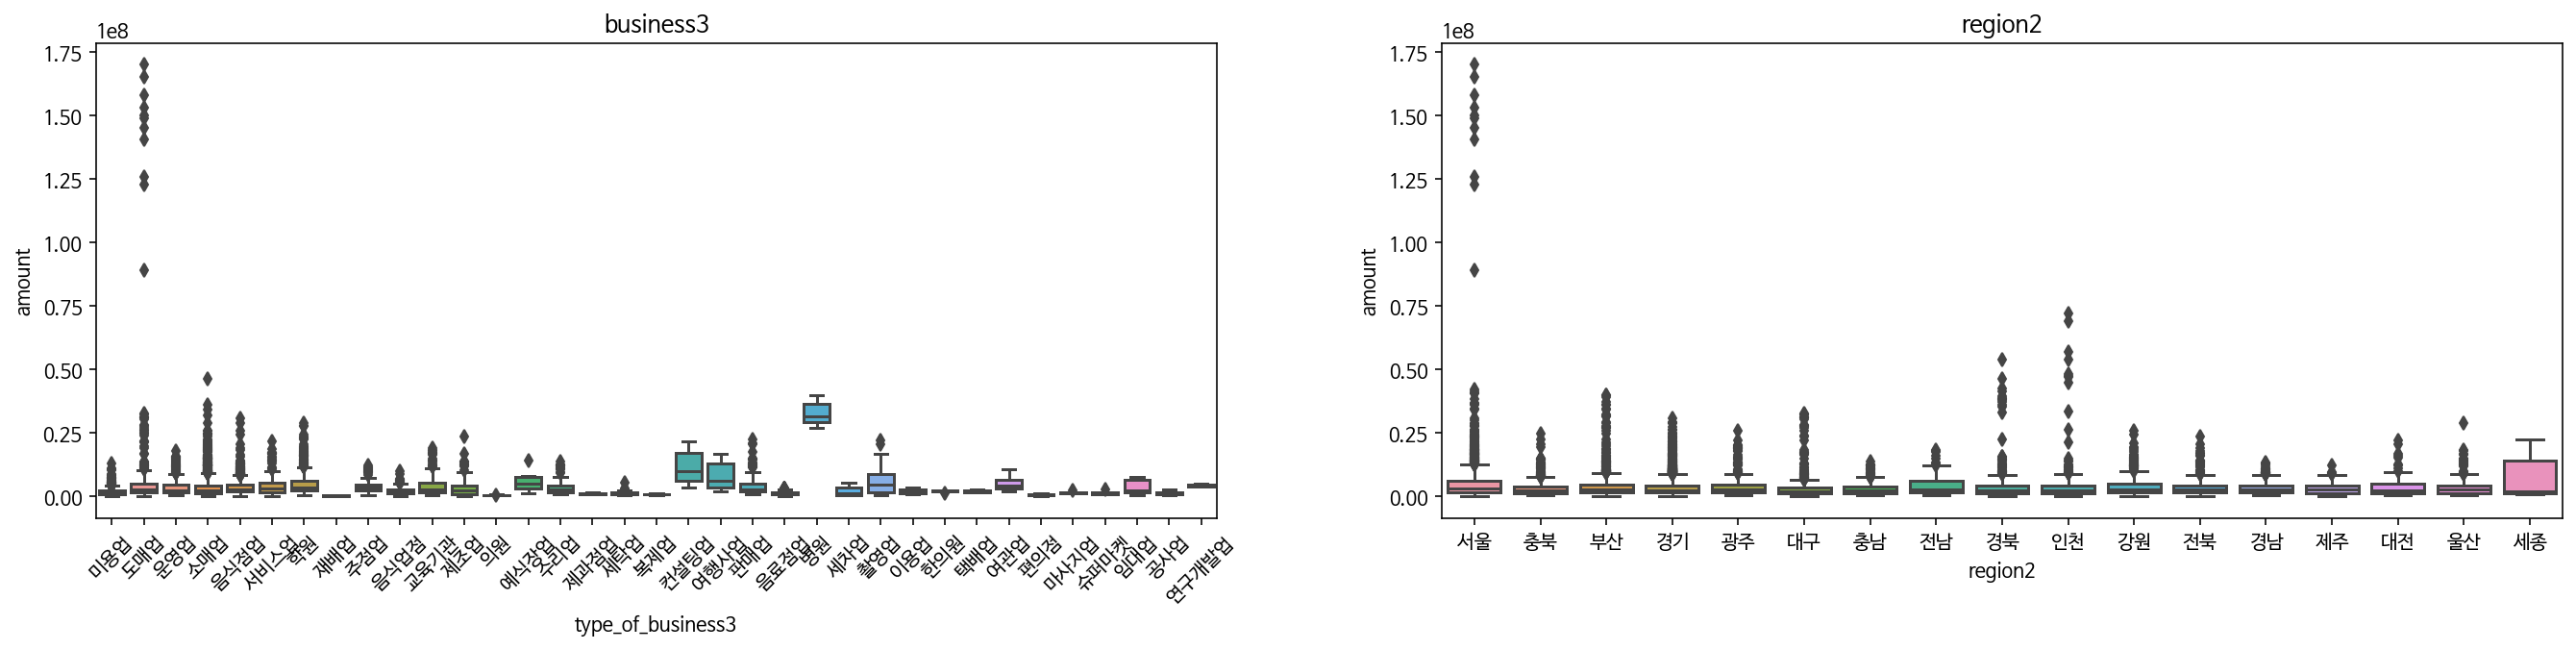

In [0]:
import warnings
warnings.filterwarnings(action='ignore') # 한글 폰트 에러 무시
plt.figure(figsize=(23,10))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
sns.boxplot(x='type_of_business3', y='amount', data=train3, ax=ax1)
for label in ax1.xaxis.get_ticklabels(): # x축의 label이 겹치지 않게 45도 회전 # https://blessingdev.wordpress.com/2018/11/15/matplotlib-%EC%82%AC%EC%9A%A9%EA%B8%B0-3%EC%B6%95-%ED%8E%B8%EC%A7%91%ED%95%98%EA%B8%B0/
    label.set_rotation(45)
ax1.set_title('business3')
sns.boxplot(x='region2', y='amount', data=train3, ax=ax2)
ax2.set_title('region2')
plt.show()

- 지역, 업종별 분포 차이 확인

In [0]:
# 더미변수화
train3 = pd.get_dummies(train3, columns=['region2', 'type_of_business3', 'quarter'])

In [0]:
train3 = train3.drop(['type_of_business', 'region', 'region3'], axis=1)

**시간별 매출비율 변수 처리**

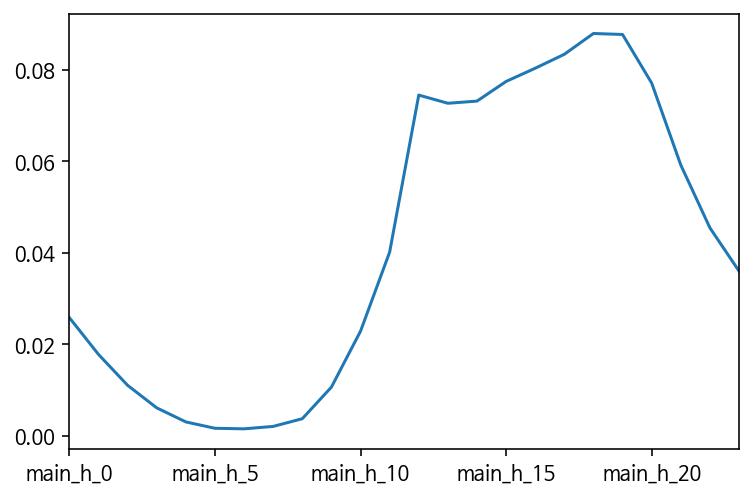

In [0]:
train3[['main_h_0', 'main_h_1', 'main_h_2',
       'main_h_3', 'main_h_4', 'main_h_5', 'main_h_6', 'main_h_7', 'main_h_8',
       'main_h_9', 'main_h_10', 'main_h_11', 'main_h_12', 'main_h_13',
       'main_h_14', 'main_h_15', 'main_h_16', 'main_h_17', 'main_h_18',
       'main_h_19', 'main_h_20', 'main_h_21', 'main_h_22', 'main_h_23']].mean().plot()

In [0]:
# 매출 비율 매우 낮은 3~8시 제거(0.3% 이하)
train3 = train3.drop(['main_h_3', 'main_h_4', 'main_h_5', 'main_h_6', 'main_h_7', 'main_h_8'], axis=1)

## 전처리

In [0]:
input_var = list(set(train3.columns) - set(['store_id','next_amt','year','region', 'open_0']))
target = 'next_amt'
log_col = []
for col in input_var:
  try:
    if data[col].mean() > 1000:
      log_col.append(col)
  except:
    pass
  
# Define train, valid
X_test = train3[train3['year_quarter']==10][input_var]
X_test_id = train3[train3['year_quarter']==10][['store_id']]

In [0]:
X_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][input_var].fillna(-9)

y_train = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][target])
X_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][input_var].fillna(-9)
y_valid = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][target])

## RF 베이지안

In [0]:
#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
   X_train, y_train, X_valid, y_valid = dataset
   n_iterations = 30
   gp_params = {"alpha": 1e-4}

   BO = BayesianOptimization(function, parameters)
   BO.maximize(n_iter=n_iterations, **gp_params)

   return BO.max

from sklearn.model_selection import cross_val_score

def rfc_optimization(cv_splits):
    def function( n_estimators, max_depth, min_samples_split):
        return RandomForestRegressor(
                   n_estimators=int(max(n_estimators,100)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=42,   
                   #class_weight="balanced"
                   ).fit(X_valid, y_valid)
               

    parameters = {"n_estimators": (100, 100),
                  "max_depth": (1, 2**6),
                  "min_samples_split": (2, 15)}
    
    return function, parameters
    
#Train model
def train_model(X_train, y_train, X_valid, y_valid, function, parameters):
    dataset = (X_train, y_train, X_valid, y_valid)
    cv_splits = 5
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestRegressor(
             n_estimators=int(max(params["n_estimators"], 100)),
             #n_estimators = 4500,
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             #class_weight="balanced"
             )

    model.fit(X_train, y_train)
    
    return model

In [0]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold

function, parameters = rfc_optimization(5)
model_best = train_model(X_train[perm_cols], y_train, X_valid[perm_cols], y_valid, function, parameters)

In [0]:
from bayes_opt import BayesianOptimization
from time import time
import datetime
def LGB_bayesian(

    min_samples_split,
    max_depth,
    n_estimators

     ):
    
    # LightGBM expects next three parameters need to be integer. 

    min_samples_split = int(min_samples_split)
    max_depth = int(max_depth)



    assert type(min_samples_split) == int
    assert type(max_depth) == int


    param = {
    
              'min_samples_split': int(round(min_samples_split)),             
              'max_depth': int(round(max_depth)),
              'n_estimators': int(round(n_estimators)),
               'criterion':'mae'}  
   
    training_start_time = time()
    start_time = time()
    model = RandomForestRegressor(**param).fit(X_train[perm_cols], y_train)
    prediction = model.predict(X_valid[perm_cols])
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    #cv_result = lgb.train(param, trn_data, folds=folds_generator, seed= 42, stratified=False, verbose_eval =1000, metrics=['mae'],
    #                   early_stopping_rounds=1000)
    return np.mean(np.abs(np.exp(y_valid.values)- np.exp(prediction)))

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'min_samples_split': (2, 30), # 크면 오버핏
    'max_depth':(2,174*2),
   'n_estimators' : (100,100)


}

In [0]:
import warnings
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

init_points = 10
n_iter = 30

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.01, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
Total training time is 1:02:06.601712


ValueError: ignored

## RF 예측

In [0]:
model1 = RandomForestRegressor(n_estimators=100, max_depth=48,min_samples_split=9,random_state=0, criterion='mse').fit(X_train[perm_cols], y_train)

In [0]:
pred = model1.predict(X_valid[perm_cols])

In [0]:
# MAE
np.mean(np.abs(np.exp(y_valid.values)- np.exp(pred)))

733018.169997741

**파라미터 : valid 점수**
- default : 790425
- n_estimators=100, max_depth=48,min_samples_split=9 : 742289

# RFE
https://www.kaggle.com/harangdev/feature-selection 

 - SHAP, Permutation을 적용한 RFE로 변수를 선택하고 결과를 비교하고자 함. 

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 2.5MB/s 


In [0]:
!pip install shap

     |████████████████████████████████| 266kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383170 sha256=74911c67846b40427200bbfdac7a7079f56b7a17a197c3593a878d6e951167e4
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
X = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<=9)][input_var].fillna(-9)
for col in log_col:
  X[col] = np.log1p(X[col])
y= train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                        (train3.year_quarter<=9)][['year_quarter','next_amt']]

In [0]:
X.shape, y.shape

((17511, 219), (17511, 2))

In [0]:
import eli5
import shap
from eli5.sklearn import PermutationImportance
def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:

        model = RandomForestRegressor(n_estimators=100, max_depth=48,min_samples_split=9,random_state=0, criterion='mse')

        x_train = x_data[(x_data.year_quarter<9)][feats]
        y_train = np.log1p(y_data[(y_data.year_quarter<9)][target])
        x_val = x_data[(x_data.year_quarter==9)][feats]
        y_val = np.log1p(y_data[(y_data.year_quarter==9)][target])   


        model.fit(x_train, y_train)
        val_pred = model.predict(x_val)
        score = np.mean(np.abs(np.exp(y_val.values)- np.exp(val_pred)))

        
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_val[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in train3[input_var].columns if col != 'next_amt']
len(feats)

219

### perm

In [0]:
perm_archive = rfe(X, y,  method= 'perm', ratio=0.9, min_feats=30)

219 742289.0982581245
197 740842.6916488407
177 738871.7547892545
159 737032.243683825
143 733018.169997741
128 734091.4999085155
115 737871.0762637712
103 741811.5440872954
92 740304.8226462891
82 745312.9211621366
73 746392.9693596531
65 742678.7936020151
58 750086.9080521057
52 748612.5111098279
46 754773.1196436362
41 754313.4082959121
36 753410.4357001666
32 757657.5796688729


In [0]:
perm_cols = perm_archive.loc[perm_archive['score'].idxmin()]['feats']
perm_archive.loc[perm_archive['score'].idxmin()]['feats']

['amount',
 'amount_lag_1',
 'amount_lag_3',
 'amount_lag_2',
 'comp_mean_amt_h',
 'seasonal_p',
 'installment_term',
 'mean_purchase_lag_2',
 'comp_mean_amt_f',
 'main_h_14',
 'amount_per_card',
 'mean_purchase',
 'is_holiday',
 'action_per_day_lag_2',
 'amount_per_card_lag_2',
 'action_per_day',
 'comp_mean_amt_e_lag_2',
 'comp_mean_amt_d',
 'main_h_11',
 'num_comp_b_lag_3',
 'main_h_15',
 'comp_mean_amt_e_lag_3',
 'comp_mean_amt_c_lag_2',
 'amt_per_business3',
 'installment_term_lag_1',
 'main_h_20',
 'main_h_16',
 'main_h_12',
 'comp_mean_amt_g_lag_1',
 'main_h_21',
 'num_comp_d_lag_1',
 'comp_mean_amt_f_lag_2',
 'comp_mean_amt_h_lag_2',
 'main_h_0',
 'comp_mean_amt_b_lag_1',
 'min_price_lag_2',
 'comp_mean_amt_f_lag_3',
 'main_h_13',
 'comp_mean_amt_g_lag_2',
 'main_h_17',
 'regular_amt_lag_2',
 'installment_term_lag_2',
 'amt_per_quarter_lag_3',
 'installment_term_lag_3',
 'min_price_lag_1',
 'type_of_business3_도매업',
 'comp_mean_amt_c_lag_3',
 'regular_amt_lag_3',
 'main_h_22',
 

733018.169997741


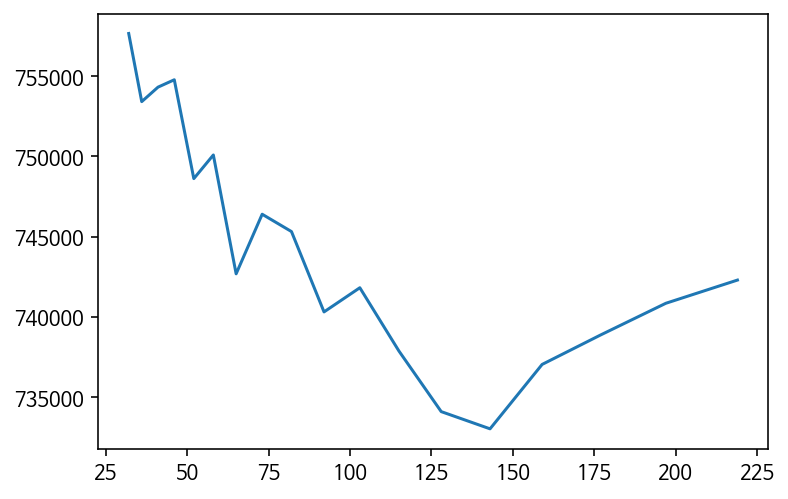

In [0]:
print(perm_archive.loc[perm_archive['score'].idxmin()]['score'])
plt.plot(perm_archive['n_feats'],perm_archive['score'])

### shap

In [0]:
shap_archive = rfe(X, y,  method= 'shap', ratio=0.9, min_feats=30)

219 741150.4371813777
197 738307.4221256978
177 742358.8793149967
159 743336.6277809681
143 740943.2781076055
128 741301.4501617741
115 744213.0631216847
103 742178.7589584397
92 744711.2194916726
82 741636.293853727
73 745228.8934903244
65 746518.7311509048
58 743422.1630103727
52 744613.2060018474
46 748314.6080225201
41 749813.5786805138
36 746903.5503126422
32 752991.6796982612


In [0]:
shap_cols = shap_archive.loc[shap_archive['score'].idxmin()]['feats']
shap_archive.loc[shap_archive['score'].idxmin()]['feats']

['amount',
 'amount_lag_1',
 'amount_lag_3',
 'amount_lag_2',
 'installment_term',
 'quarter_4',
 'quarter_1',
 'seasonal_p',
 'comp_mean_amt_b',
 'is_holiday',
 'main_h_14',
 'action_per_day',
 'comp_mean_amt_h',
 'mean_purchase_lag_2',
 'installment_term_lag_1',
 'year_quarter',
 'comp_mean_amt_f',
 'comp_mean_amt_c',
 'comp_mean_amt_d',
 'main_h_13',
 'regular_amt',
 'num_comp_b',
 'comp_mean_amt_g',
 'comp_mean_amt_a',
 'comp_mean_amt_b_lag_2',
 'amount_per_card_lag_2',
 'main_h_16',
 'comp_mean_amt_e',
 'business3_amt',
 'regular_amt_lag_1',
 'main_h_15',
 'main_h_20',
 'min_price_lag_3',
 'comp_mean_amt_e_lag_2',
 'amount_per_card',
 'business3_amt_lag_2',
 'comp_mean_amt_h_lag_1',
 'installment_term_lag_2',
 'comp_mean_amt_f_lag_3',
 'amt_per_quarter',
 'comp_mean_amt_f_lag_1',
 'main_h_11',
 'mean_purchase',
 'comp_mean_amt_c_lag_2',
 'main_h_19',
 'main_h_21',
 'main_h_10',
 'num_comp_f',
 'num_comp_d_lag_1',
 'num_comp_h',
 'installment_term_lag_3',
 'main_h_9',
 'comp_mean_amt_d_lag_3',
 'num_comp_a',
 'num_comp_e',
 'amt_per_region2_lag_3',
 'comp_mean_amt_b_lag_1',
 'main_h_17',
 'main_h_18',
 'min_price',
 'min_price_lag_1',
 'comp_mean_amt_e_lag_3',
 'num_comp_c',
 'num_comp_d',
 'num_comp_e_lag_3',
 'main_h_12',
 'main_h_2',
 'comp_mean_amt_g_lag_1',
 'num_card_id',
 'main_h_22',
 'num_comp_a_lag_1',
 'num_comp_d_lag_3',
 'comp_mean_amt_f_lag_2',
 'num_card_id_lag_1',
 'amt_per_region2',
 'comp_mean_amt_g_lag_2',
 'is_holiday_lag_3',
 'refund',
 'comp_mean_amt_h_lag_3',
 'comp_mean_amt_d_lag_2',
 'comp_mean_amt_b_lag_3',
 'regular_amt_lag_2',
 'action_per_day_lag_3',
 'is_holiday_lag_2',
 'num_comp_b_lag_3',
 'comp_mean_amt_e_lag_1',
 'num_comp_g',
 'regular',
 'comp_mean_amt_d_lag_1',
 'action_per_day_lag_1',
 'quarter_amt',
 'comp_mean_amt_a_lag_1',
 'comp_mean_amt_g_lag_3',
 'comp_mean_amt_c_lag_1',
 'num_comp_h_lag_1',
 'regular_amt_lag_3',
 'mean_purchase_lag_1',
 'main_h_23',
 'num_comp_a_lag_2',
 'action_per_day_lag_2',
 'num_comp_b_lag_2',
 'num_comp_e_lag_1',
 'num_comp_f_lag_1',
 'num_comp_b_lag_1',
 'comp_mean_amt_h_lag_2',
 'business3_amt_lag_3',
 'refund_lag_2',
 'num_comp_c_lag_1',
 'num_comp_e_lag_2',
 'region2_amt_lag_2',
 'region2_amt_lag_1',
 'region2_amt',
 'comp_mean_amt_c_lag_3',
 'num_comp_c_lag_2',
 'min_price_lag_2',
 'refund_lag_3',
 'num_comp_d_lag_2',
 'refund_lag_1',
 'num_comp_f_lag_2',
 'amt_per_business3_lag_3',
 'comp_mean_amt_a_lag_3',
 'num_card_id_lag_2',
 'num_comp_h_lag_2',
 'num_comp_g_lag_1',
 'main_h_0',
 'is_holiday_lag_1',
 'num_comp_c_lag_3',
 'quarter_amt_lag_2',
 'comp_mean_amt_a_lag_2',
 'amt_per_business3',
 'num_comp_g_lag_2',
 'amt_per_quarter_lag_3',
 'num_comp_g_lag_3',
 'num_comp_h_lag_3',
 'num_comp_a_lag_3',
 'main_h_1',
 'amount_per_card_lag_1',
 'region2_amt_lag_3',
 'num_comp_f_lag_3',
 'regular_lag_1',
 'mean_purchase_lag_3',
 'num_card_id_lag_3',
 'amt_per_region2_lag_1',
 'business3_amt_lag_1',
 'quarter_amt_lag_1',
 'amt_per_region2_lag_2',
 'regular_lag_3',
 'amount_per_card_lag_3',
 'amt_per_quarter_lag_2',
 'regular_lag_2',
 'quarter_amt_lag_3',
 'amt_per_business3_lag_2',
 'weekend_store',
 'type_of_business3_도매업',
 'amt_per_business3_lag_1',
 'amt_per_quarter_lag_1',
 'type_of_business3_음식점업',
 'quarter_3',
 'open_time_0',
 'type_of_business3_소매업',
 'type_of_business3_운영업',
 'is_point',
 'quarter_2',
 'region2_경기',
 'region2_경북',
 'is_point_lag_1',
 'type_of_business3_미용업',
 'region2_충북',
 'region2_부산',
 'region2_광주',
 'region2_전북',
 'region2_충남',
 'region2_서울',
 'open_6',
 'region2_제주',
 'region2_강원',
 'is_point_lag_3',
 'is_point_lag_2',
 'region2_대구',
 'region2_전남',
 'type_of_business3_촬영업',
 'region2_인천',
 'region2_대전',
 'type_of_business3_슈퍼마켓',
 'region2_경남',
 'type_of_business3_음식업점',
 'open_time_3',
 'type_of_business3_제조업',
 'type_of_business3_공사업',
 'region2_울산',
 'open_time_1',
 'region2_세종',
 'type_of_business3_판매업',
 'type_of_business3_서비스업',
 'type_of_business3_주점업',
 'type_of_business3_세탁업',
 'type_of_business3_교육기관']

738307.4221256978


[<matplotlib.lines.Line2D at 0x7f1c480d38d0>]

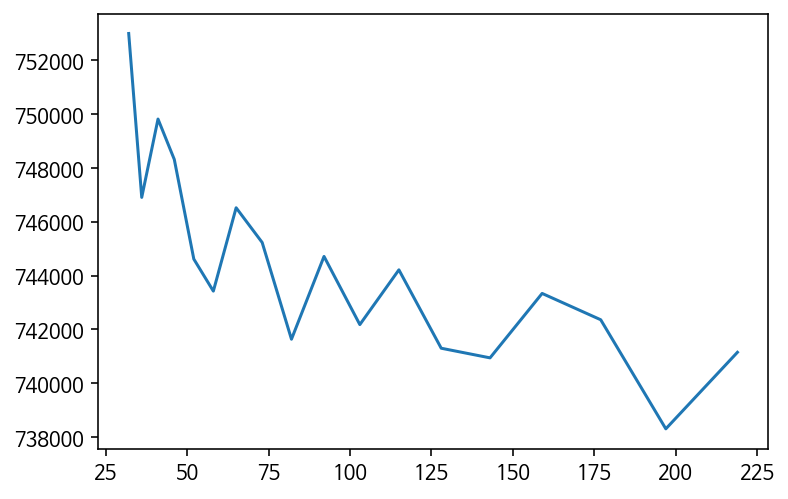

In [0]:
print(shap_archive.loc[shap_archive['score'].idxmin()]['score'])
plt.plot(shap_archive['n_feats'],shap_archive['score'])

# 예측 테스트

## 전처리2

In [0]:
train2 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Preprocessing/train_basic.csv') # 추제 정보 없는 파일

In [0]:
# 다음 분기 매출량 계산을 위한 함수
def lag_feature1(df, lags, col):
    tmp = df[['year_quarter','store_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['year_quarter','store_id', col+'_lag_'+str(i)]
        shifted['year_quarter'] -= i
        df = pd.merge(df, shifted, on=['year_quarter','store_id'], how='left')
    return df
    
# 추세 정보를 넣기 위한 함수
def lag_feature2(df, lags, col):
    tmp = df[['year_quarter','store_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['year_quarter','store_id', col+'_lag_'+str(i)]
        shifted['year_quarter'] += i
        df = pd.merge(df, shifted, on=['year_quarter','store_id'], how='left')
    return df

In [0]:
train3 = train2.copy()
train3 = lag_feature1(train3, [1], 'amount')
train3 = train3.rename(columns={'amount_lag_1':'next_amt'})

for col in ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'business3_amt', 'amt_per_business3',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h']:

  train3 = lag_feature2(train3, [1,2,3], col)

In [0]:
# 더미변수화
train3 = pd.get_dummies(train3, columns=['region2', 'type_of_business3', 'quarter'])
train3 = train3.drop(['type_of_business', 'region', 'region3'], axis=1)
# 매출 비율 매우 낮은 3~8시 제거(0.3% 이하)
train3 = train3.drop(['main_h_3', 'main_h_4', 'main_h_5', 'main_h_6', 'main_h_7', 'main_h_8'], axis=1)

## 예측

In [0]:
# 선택한 변수로 학습 및 예측
def make_fit_predict(input_cols, X_train, y_train, data):
  model1 = RandomForestRegressor(n_estimators=100, max_depth=48,min_samples_split=9,
                                 random_state=0, criterion='mse').fit(X_train[input_cols], y_train)
  # 19년도 1분기(year_quarter = 10) 데이터로 2분기 예측
  X_test = train3[(train3.year_quarter==10)][input_cols].fillna(-9) # 예측을 위해 결측 처리
  X_test_id = train3[(train3.year_quarter==10)][['store_id']] # 
  pred = model1.predict(X_test)
  X_test_id['amount'] = np.exp(pred)
  return X_test_id

In [0]:
# 예측
X_test_id = make_fit_predict(shap_cols, X_train, y_train, train3)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/submission.csv')
train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Preprocessing/funda_train_prep.csv')
train4 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv')

# 19년 1분기에 매출이 없는 가게들은 과거 같은 분기 매출액으로 대체
rest_store = list(set(train.store_id.unique()) - set(X_test_id.store_id.unique())) # 19년 1분기 매출이 없는 가게
rest_2018_1 = train4.loc[(train4['store_id'].isin(rest_store)) & (train4['quarter']==2) & (train4['year']==2018)][['store_id','amount']] # 18년 2분기로 대체

rest_list1 = set(rest_store) - set(rest_2018_1.store_id.unique())
rest_2018_2 = train4.loc[(train4['store_id'].isin(rest_list1)) & (train4['quarter']==2) & (train4['year']==2017)][['store_id','amount']] # 17년 2분기로 대체

rest_list2 = set(rest_list1) - set(rest_2018_2.store_id.unique())
rest_2018_3 = train4.loc[(train4['store_id'].isin(rest_list2))][['store_id','amount']] # 17년 2분기로 대체
rest_2018_3 = rest_2018_3.groupby('store_id').mean().reset_index()

reset_st = pd.concat([rest_2018_1, rest_2018_2,rest_2018_3], axis=0)

In [0]:
X_test_id = pd.concat([X_test_id, reset_st], axis=0) # 예측값 병합

In [0]:
submission2 = pd.merge(submission.drop('amount',axis=1),X_test_id, on='store_id')

# 결과

In [0]:
# 1. 기본 컬럼 
#submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/RF_submission_1227.csv',index=False)
# valid = 742,289
# score = 818,538
# 
# parameter
# |   iter    |  target   | max_depth | min_sa... | n_esti... |
# -------------------------------------------------------------
# |  1        | -0.1532   |  47.78    |  9.472    |  100.0    |

In [0]:
# 2. permutation RFE 컬럼
#submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/RF_submission_1227_perm_cols.csv',index=False)
# valid = 733018
# test = 825768

In [0]:
# 3. shap RFE 컬럼
#submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/RF_submission_1227_shap_cols.csv',index=False)
# valid = 738307
# test = 819897

**결론**
 
- 점수 순위: 1. all column, 2. SHAP, 3. Permutation
  - 이번 data set에서는 비록 변수 선택을 하지 않았을 때 가장 오차가 적었지만, 서로 크게 차이는 나지 않았다(10,000점 이하).
  - 따라서 모델 경량화를 원한다면 FE를 해도 예측상의 큰 손해는 없다.
- 모델 비교: 1. RF, 2. LGBM (약 40,000점 차이)
 - Kaggle을 접하면서 GBM 계열에만 집중하고 RF를 무시한 경향이 있었다.
 - 하지만 데이터 상태(노이즈가 많은 경우 등)에 따라 RF가 더 적합한 모델이 될 수 있다는 점을 알 수 있었다. 
 
 (이번에 valid에선 LGBM이 100,000점 정도 MAE가 낮았는데, test 점수에서는 40,000점이나 MAE가 높았다. 즉, LGBM은 오버피팅되어 있었다.)
 


In [0]:
# https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained